### AML3104 Assignment 5: Artificial Neural Network (ANN) vs Linear Regression for California Housing Data

__Student Name:__ Auradee Castro | __Student Number:__ c0866821

-------------------------------------------------------------

__Objective:__ The objective of this assignment is to implement and compare the performance of an Artificial Neural Network (ANN) and Linear Regression for predicting house prices using the California Housing dataset.

__Dataset:__ Use the California Housing dataset, which contains various features related to housing in California. You can load the dataset using scikit-learn:

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras as ks

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import model_to_dot

Load the California housing dataset

In [5]:
housing = fetch_california_housing()
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [6]:
# Get the dataset features
housing_df = pd.DataFrame(housing.data, columns=housing.feature_names)
# Get the target featur
housing_df['MedHouseVal'] = pd.DataFrame(housing.target, columns=['MedHouseVal'])

housing_df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Data Preprocessing

In [7]:
# Get the statistical overview of the dataset
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [8]:
# Check for null values
housing_df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [9]:
# Drop if there are duplicate records
print(f"Record count before removing duplicates => {housing_df.shape[0]}")
housing_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {housing_df.shape[0]}")

Record count before removing duplicates => 20640
Record count after removing duplicates  => 20640


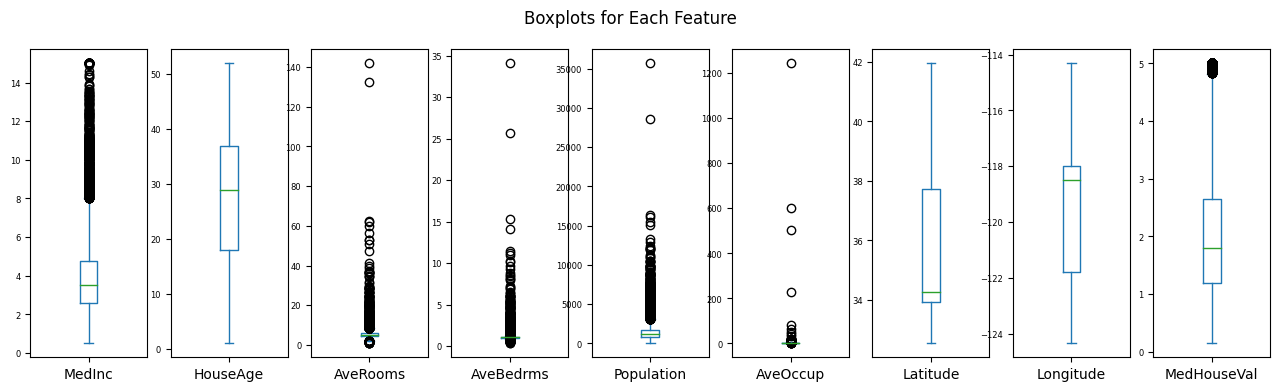

In [10]:
# Check for outliers by creating a separate boxplot subplots for each feature
fig, axes = plt.subplots(1, housing_df.shape[1], figsize=(16, 4))
for i, (col, ax) in enumerate(zip(housing_df.columns, axes)):
    housing_df[col].plot(kind='box', ax=ax)
    ax.tick_params(axis='y', labelsize=6)

plt.suptitle('Boxplots for Each Feature')
plt.show()

__Observation:__ From the chart above, there are noticeable extreme outliers in `AveRooms`, `AveBedrms`, `Population` and `AveOccup` columns. Drop those outliers from the dataset.

In [11]:
print(f"Record count before dropping outlier => {housing_df.shape[0]}")

housing_df = housing_df[(housing_df['AveRooms'] < 80) & 
                        (housing_df['AveBedrms'] < 25) & 
                        (housing_df['Population'] < 25000) &
                        (housing_df['AveOccup'] < 200)]

print(f"Record count after dropping outlier  => {housing_df.shape[0]}")

Record count before dropping outlier => 20640
Record count after dropping outlier  => 20632


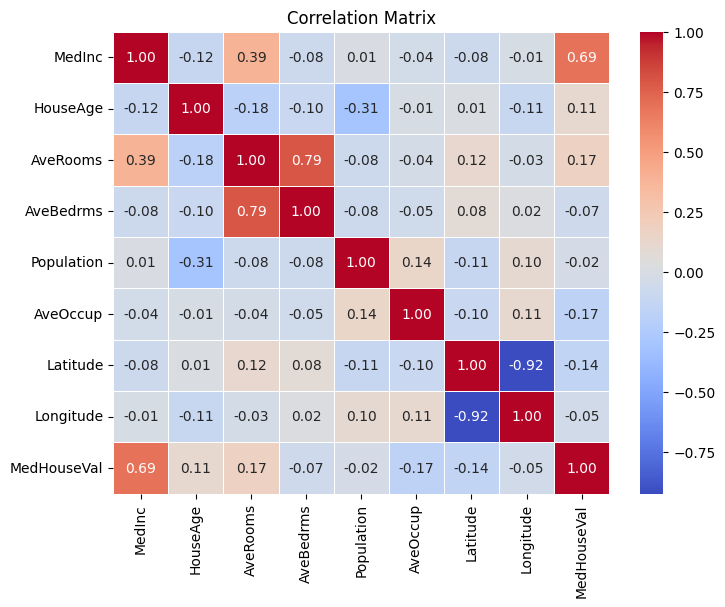

In [12]:
# Check the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(housing_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [13]:
# Check whether the feature is important or not using VIF (variance inflation factor)
# NOTE: Feature might not be important with higher VIF
data_with_const = add_constant(housing_df)

vif_data = pd.DataFrame()
vif_data["Variable"] = data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])]

print(vif_data)

      Variable           VIF
0        const  20020.552812
1       MedInc      4.023104
2     HouseAge      1.285890
3     AveRooms      6.731009
4    AveBedrms      5.332635
5   Population      1.165796
6     AveOccup      1.093202
7     Latitude     11.130940
8    Longitude     10.603355
9  MedHouseVal      2.677218


In [14]:
# Drop `Latitude` and `Longitude` from the dataset as they have VIF higher than 7 (as mentioned in the class)
housing_df = housing_df.drop(columns=['Latitude', 'Longitude'], axis=1)
housing_df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422


### Splitting Dataset

In [15]:
X = housing_df.drop(columns=['MedHouseVal'], axis=1)
y = housing_df['MedHouseVal']

# Split dataset into train and test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

print('Training inputs =>', X_train.shape)
print('Training labels =>', y_train.shape)
print('Validation inputs =>', X_val.shape)
print('Validation labels =>', y_val.shape)
print('Testing inputs  =>', X_test.shape)
print('Testing labels  =>', y_test.shape)

Training inputs => (13204, 6)
Training labels => (13204,)
Validation inputs => (3301, 6)
Validation labels => (3301,)
Testing inputs  => (4127, 6)
Testing labels  => (4127,)


### Standardized Dataset

In [16]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

### Model Creation and Evaluation

__For Linear Regression__

In [17]:
# Train the model on the training set
model_reg = LinearRegression()
model_reg.fit(X_train_sc, y_train)
print(f"Model: {model_reg}")

Model: LinearRegression()


In [51]:
def evaluate_model(X, y, model):
    # Make predictions on the training set
    y_pred = model.predict(X)

    # Evaluate the linear regression model
    print("MAE: ", round(mean_absolute_error(y, y_pred), 4))
    print("MSE: ", round(mean_squared_error(y, y_pred), 4))
    print("R2 Score: ", round(r2_score(y, y_pred), 4))


print("Evaluation Metrics for Train Data")
evaluate_model(X_train_sc, y_train, model_reg)

print("\nEvaluation Metrics for Test Data")
evaluate_model(X_test_sc, y_test, model_reg)

Evaluation Metrics for Train Data
MAE:  0.5547
MSE:  0.577
R2 Score:  0.5676

Evaluation Metrics for Test Data
MAE:  0.5581
MSE:  0.5915
R2 Score:  0.5576


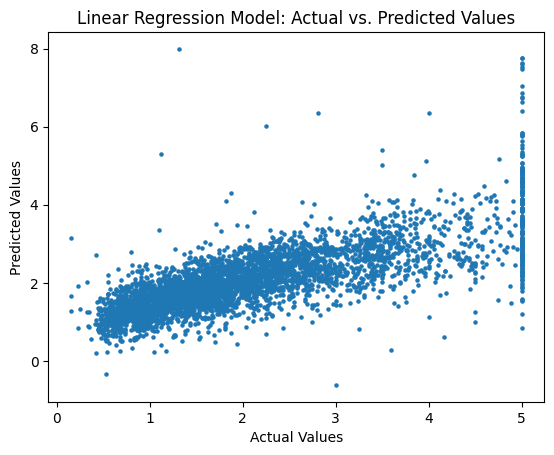

In [94]:
plt.scatter(y_test, y_pred_reg, s=5, label='Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression Model: Actual vs. Predicted Values')
plt.show()

__For Artificial Neural Network (ANN)__

_ANN Model Architecture_

![ANN Model Architecture](./ann_model_architecture.PNG)

In [87]:
# Design the architecture of the neural network
Layers = [
    Dense(units=20, activation="relu", input_shape=X_train_sc.shape[1:], name='InputLayer'),
    BatchNormalization(name='BatchNormalization'),
    Dense(units=10, activation="relu", name='HiddenLayer'),
    Dense(units=1, name='OutputLayer')
]

model_ann = Sequential(Layers)
model_ann.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Dense)          (None, 20)                140       
                                                                 
 BatchNormalization (BatchNo  (None, 20)               80        
 rmalization)                                                    
                                                                 
 HiddenLayer (Dense)         (None, 10)                210       
                                                                 
 OutputLayer (Dense)         (None, 1)                 11        
                                                                 
Total params: 441
Trainable params: 401
Non-trainable params: 40
_________________________________________________________________


In [88]:
# Compile the ANN model
model_ann.compile(optimizer='sgd', loss='mse')

In [89]:
EPOCHS = 40
# Train the model with validation on the training set
history = model_ann.fit(X_train_sc, y_train, epochs=EPOCHS, validation_data=(X_val_sc, y_val))

Epoch 1/40


413/413 [==============================] - 2s 3ms/step - loss: 0.7427 - val_loss: 0.5255
Epoch 2/40
413/413 [==============================] - 1s 3ms/step - loss: 0.5101 - val_loss: 0.4597
Epoch 3/40
413/413 [==============================] - 1s 2ms/step - loss: 0.4940 - val_loss: 0.4536
Epoch 4/40
413/413 [==============================] - 1s 2ms/step - loss: 0.4787 - val_loss: 0.4478
Epoch 5/40
413/413 [==============================] - 1s 2ms/step - loss: 0.4723 - val_loss: 0.4665
Epoch 6/40
413/413 [==============================] - 1s 2ms/step - loss: 0.4768 - val_loss: 0.4401
Epoch 7/40
413/413 [==============================] - 1s 2ms/step - loss: 0.4686 - val_loss: 0.4388
Epoch 8/40
413/413 [==============================] - 1s 2ms/step - loss: 0.4588 - val_loss: 0.4334
Epoch 9/40
413/413 [==============================] - 1s 2ms/step - loss: 0.4624 - val_loss: 0.4325
Epoch 10/40
413/413 [==============================] - 1s 2ms/step - loss: 0.4579 - val_loss: 0.4377
Epoch 11/4

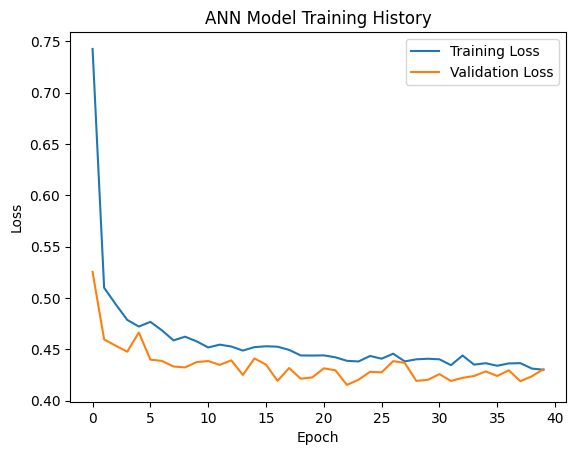

In [90]:
# Training and Validation Loss history when training ANN model
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:
# Loss value on test dataset
print("Loss:", model_ann.evaluate(X_test_sc, y_test))

129/129 [==============================] - 0s 1ms/step - loss: 0.4352
Loss: 0.435222327709198


In [92]:
print("Evaluation Metrics for Train Data")
evaluate_model(X_train_sc, y_train, model_ann)

print("\nEvaluation Metrics for Test Data")
evaluate_model(X_test_sc, y_test, model_ann)

Evaluation Metrics for Train Data
413/413 [==============================] - 0s 913us/step
MAE:  0.4588
MSE:  0.4073
R2 Score:  0.6947

Evaluation Metrics for Test Data
129/129 [==============================] - 0s 1ms/step
MAE:  0.4706
MSE:  0.4352
R2 Score:  0.6745


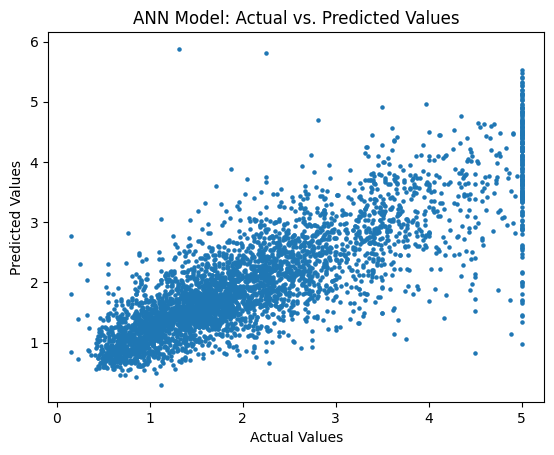

In [95]:
plt.scatter(y_test, y_pred_ann, s=5, label='Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('ANN Model: Actual vs. Predicted Values')
plt.show()

### Conclusion: Model Comparison and Analysis

The ANN model outperforms the linear regression model based on the provided metrics. The lower values for MAE and MSE, along with the higher R2 Score, indicate that the ANN captures more of the variance in the target variable and makes more accurate predictions on the California Housing Dataset. With small difference between the train and test data metrics, ANN model does not show overfitting issues. The complexity of an ANN allows it to capture intricate patterns and relationships within the data, making it a powerful tool for predictive tasks. However, this complexity comes with trade-offs, such as increased computational requirements.

__Performance Metrics:__

| Model                           | MAE       | MSE       | R2 Score |
| ------------------------------- | --------- | --------- | -------- |
| Linear Regression               | 0.5581    | 0.5915    | 0.5576   |
| Artifinal Neural Network (ANN)  | 0.4588    | 0.4073    | 0.6947   |

Nevertheless, the ANN's ability to capture nonlinear patterns in the California Housing Dataset seems more beneficial, resulting in better predictive performance compared to the simpler linear regression model. 